HMA1 Class
==========

In this guide we will go through a series of steps that will let you
discover functionalities of the `HMA1` class.

What is HMA1?
-------------

The `sdv.relational.HMA1` class implements what is called a
*Hierarchical Modeling Algorithm* which is an algorithm that allows to
recursively walk through a relational dataset and apply tabular models
across all the tables in a way that lets the models learn how all the
fields from all the tables are related.

Let's now discover how to use the `HMA1` class.

Quick Usage
-----------

We will start by loading and exploring one of our demo datasets.

In [1]:
from sdv.demo import sample_relational_demo

metadata, tables = sample_relational_demo(size=30)

This will return two objects:

1.  A `Metadata` object with all the information that **SDV** needs to
    know about the dataset.

In [2]:
metadata

Metadata
  root_path: .
  tables: ['users', 'sessions', 'transactions']
  relationships:
    sessions.user_id -> users.user_id
    transactions.session_id -> sessions.session_id

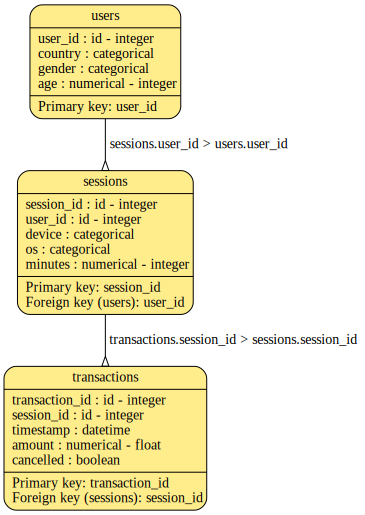

In [3]:
metadata.visualize()

For more details about how to build the `Metadata` for your own dataset,
please refer to the [relational_metadata](relational_metadata.ipynb)
Guide.

2.  A dictionary containing three `pandas.DataFrames` with the tables
    described in the metadata object.

In [4]:
from sdv.utils import display_tables

display_tables(tables)

In [5]:
for name, table in tables.items():
    print(name, table.shape)

users (30, 4)
sessions (52, 5)
transactions (165, 5)


Let us now use the `HMA1` class to learn this data to be ready to sample
synthetic data about new users. In order to do this you will need to:

-   Import the `sdv.relational.HMA1` class and create an instance of it
    passing the `metadata` that we just loaded.
-   Call its `fit` method passing the `tables` dict.

In [6]:
from sdv.relational import HMA1

model = HMA1(metadata)
model.fit(tables)

<div class="alert alert-info">

**Note**

During the previous steps SDV walked through all the tables in the
dataset following the relationships specified by the metadata, learned
each table using a [gaussian_copula](gaussian_copula.ipynb) and
then augmented the parent tables using the copula parameters before
learning them. By doing this, each copula model was able to learn how
the child table rows were related to their parent tables.

</div>

### Generate synthetic data from the model

Once the training process has finished you are ready to generate new
synthetic data by calling the `sample_all` method from your model.

In [7]:
new_data = model.sample()

This will return a dictionary of tables identical to the one which the
model was fitted on, but filled with new data which resembles the
original one.

In [8]:
display_tables(new_data)

In [9]:
for name, table in new_data.items():
    print(name, table.shape)

users (30, 4)
sessions (42, 5)
transactions (121, 5)


### Save and Load the model

In many scenarios it will be convenient to generate synthetic versions
of your data directly in systems that do not have access to the original
data source. For example, if you may want to generate testing data on
the fly inside a testing environment that does not have access to your
production database. In these scenarios, fitting the model with real
data every time that you need to generate new data is feasible, so you
will need to fit a model in your production environment, save the fitted
model into a file, send this file to the testing environment and then
load it there to be able to `sample` from it.

Let's see how this process works.

#### Save and share the model

Once you have fitted the model, all you need to do is call its `save`
method passing the name of the file in which you want to save the model.
Note that the extension of the filename is not relevant, but we will be
using the `.pkl` extension to highlight that the serialization protocol
used is [pickle](https://docs.python.org/3/library/pickle.html).

In [10]:
model.save('my_model.pkl')

This will have created a file called `my_model.pkl` in the same
directory in which you are running SDV.

<div class="alert alert-info">

**Important**

If you inspect the generated file you will notice that its size is much
smaller than the size of the data that you used to generate it. This is
because the serialized model contains **no information about the
original data**, other than the parameters it needs to generate
synthetic versions of it. This means that you can safely share this
`my_model.pkl` file without the risc of disclosing any of your real
data!

</div>

#### Load the model and generate new data

The file you just generated can be send over to the system where the
synthetic data will be generated. Once it is there, you can load it
using the `HMA1.load` method, and then you are ready to sample new data
from the loaded instance:

In [11]:
loaded = HMA1.load('my_model.pkl')
new_data = loaded.sample()
new_data.keys()

dict_keys(['users', 'sessions', 'transactions'])

<div class="alert alert-warning">

**Warning**

Notice that the system where the model is loaded needs to also have
`sdv` installed, otherwise it will not be able to load the model and use
it.

</div>

### How to control the number of rows?

In the steps above we did not tell the model at any moment how many rows
we wanted to sample, so it produced as many rows as there were in the
original dataset.

If you want to produce a different number of rows you can pass it as the
`num_rows` argument and it will produce the indicated number of rows:

In [12]:
model.sample(num_rows=5)

{'users':    user_id country gender  age
 0       30      KM      M   22
 1       31      ML      M   34
 2       32      HR      M   38
 3       33      HR      F   30
 4       34      ML      M   39,
 'sessions':    session_id  user_id  device       os  minutes
 0          42       30      pc  android       26
 1          43       30      pc  android       42
 2          44       31  tablet  android       38
 3          45       31      pc    linux       19
 4          46       31  tablet  android       34
 5          47       34  tablet    macos       50,
 'transactions':     transaction_id  session_id           timestamp      amount  cancelled
 0              121          42 2018-12-05 19:16:46   24.227721      False
 1              122          42 2018-12-05 19:22:18   49.164380      False
 2              123          42 2018-12-05 19:21:21   25.373342      False
 3              124          42 2018-12-05 19:22:03   41.184365      False
 4              125          42 2018-12-05 1

<div class="alert alert-info">

**Note**

Notice that the root table `users` has the indicated number of rows but
some of the other tables do not. This is because the number of rows from
the child tables is sampled based on the values form the parent table,
which means that only the root table of the dataset is affected by the
passed `num_rows` argument.

</div>

### Can I sample a subset of the tables?

In some occasions you will not be interested in generating rows for the
entire dataset and would rather generate data for only one table and its
children.

To do this you can simply pass the name of table that you want to
sample.

For example, pass the name `sessions` to the `sample` method, the model
will only generate data for the `sessions` table and its child table,
`transactions`.

In [13]:
model.sample('sessions', num_rows=5)

{'sessions':    session_id  user_id  device       os  minutes
 0          48       35  tablet  android       28
 1          49       36  tablet  android       21
 2          50       36  tablet  android       52
 3          51       35      pc  android       44
 4          52       35      pc  android       81,
 'transactions':     transaction_id  session_id           timestamp      amount  cancelled
 0              141          48 2019-08-11 22:34:04   86.234198       True
 1              142          48 2019-08-11 22:24:27   11.638982      False
 2              143          48 2019-08-11 22:25:07  100.367608       True
 3              144          48 2019-08-11 22:15:53   84.186588      False
 4              145          48 2019-08-11 22:18:00   86.119963      False
 5              146          49 2019-09-30 03:41:09  122.177933      False
 6              147          49 2019-09-30 03:41:09  105.816706       True
 7              148          50 2019-06-16 22:30:15  102.423613      Fa

If you want to further restrict the sampling process to only one table
and also skip its child tables, you can add the argument
`sample_children=False`.

For example, you can sample data from the table `users` only without
producing any rows for the tables `sessions` and `transactions`.

In [14]:
model.sample('users', num_rows=5, sample_children=False)

,user_id,country,gender,age
0,38,GM,M,33
1,39,UY,M,37
2,40,UY,M,16
3,41,UY,M,27
4,42,ML,M,34


<div class="alert alert-info">

**Note**

In this case, since we are only producing a single table, the output is
given directly as a `pandas.DataFrame` instead of a dictionary.

</div>